<a href="https://colab.research.google.com/github/jjhurtadoa/Modelos-/blob/main/ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Leer archivos desde Kaggle

In [ ]:

!pip install -U kaggle

Ir a perfil de Kaggle--> Account--> Create New API Token. Esto generará un json necesario para acceder a la data en Kaggle sin tener que descargarla

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanjosehurtado","key":"b22c794e7579fcf4388a8ab3707093d5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

 99% 1.01G/1.03G [00:08<00:00, 117MB/s]
100% 1.03G/1.03G [00:08<00:00, 130MB/s]


In [ ]:
!unzip -q asl-alphabet.zip -d .

In [ ]:
data_dir = ('/content/asl_alphabet_train/asl_alphabet_train')
data_dir_test= ('/content/asl_alphabet_test/asl_alphabet_test')

## Importar librerías y creación del dataset

In [ ]:
# Librerías.
from IPython.display import set_matplotlib_formats
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from matplotlib.pyplot import imshow
import cv2
import re

import os


# Configuraciones de librerías.
set_matplotlib_formats("svg")
matplotlib.rcParams["axes.facecolor"] = "white"
sns.set(style="darkgrid")

# Constantes.
WORKSPACE_FOLDER_PATH = "/content/drive/MyDrive/Tecno-Inclusion"
#LABELS_DATASET_FILENAME = "Labels.csv"
DATASET_FOLDER_NAME = "Dataset"
OUTPUT_FOLDER_NAME = "Outputs"

RESNET50_INPUT_SHAPE = (50, 50, 3)
TEST_SET_FRACTION = 0.2  # Fracción de todo el conjunto de datos.
STOPPING_PATIENCE = 8  # Epochs
LR_PATIENCE = 4  # Epochs
MODEL_V1_NAME = "model_v1"
INITIAL_LR = 0.0001
BATCH_SIZE = 32
MAX_EPOCHS = 25
VALIDATION_SET_FRACTION = 0.2  # Fracción del conjunto de entrenamiento.

In [ ]:
Name=os.listdir(data_dir)

print(Name)
print(len(Name))


['O', 'S', 'X', 'V', 'P', 'G', 'M', 'Q', 'del', 'J', 'N', 'Z', 'I', 'R', 'K', 'A', 'D', 'U', 'E', 'C', 'nothing', 'B', 'W', 'L', 'H', 'T', 'Y', 'space', 'F']
29


In [ ]:
Name = sorted(Name)
print(Name)
print(len(Name))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


In [ ]:
data_image=[]
data_label=[]
count=0
for name in tqdm(Name):
    path=os.path.join(data_dir,name)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
        image=img_to_array(image)
        image=image/255.0
        data_image+=[image]
        data_label+=[count]
    count+=1

100%|██████████| 29/29 [01:30<00:00,  3.11s/it]


In [ ]:
dataset= np.array(data_image)
labels= np.array(data_label)


In [ ]:
def show_image( letra, archivo):
  carpeta= path=os.path.join(data_dir, letra)
  img = cv2.imread(os.path.join(path, archivo))
  plt.rcParams["axes.grid"] = False  
  print("True label: ", letra)
  
  plt.imshow(img)


True label:  A


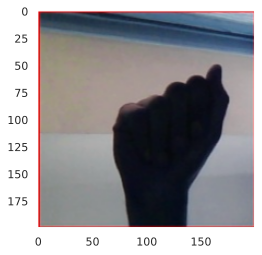

In [ ]:
show_image( 'A', 'A100.jpg')

In [ ]:
print(f'Dimensiones de "dataset": {dataset.shape}')
print(f'Dimensiones de "labels": {labels.shape}')

Dimensiones de "dataset": (87000, 50, 50, 3)
Dimensiones de "labels": (87000,)


## Partición de datos y creación del modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  dataset, labels, test_size=TEST_SET_FRACTION, random_state=1, stratify=labels
)

# Se libera memoria.
del dataset

print(f'Dimensiones de "X_train": {X_train.shape}')
print(f'Dimensiones de "X_test": {X_test.shape}')

Dimensiones de "X_train": (69600, 50, 50, 3)
Dimensiones de "X_test": (17400, 50, 50, 3)


In [ ]:
def create_custom_resnet50(resnet50_input_shape,
                           number_classes,
                           model_name,
                           initial_lr,
                           block_pretrained_layers=False):

  # Se carga una CNN con arquitectura ResNet50 preentrenada en ImageNet.
  resnet50_model_base = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=resnet50_input_shape
  )

  if block_pretrained_layers:

    # Se impide que las capas preentrenadas sean entrenables.
    for layer in resnet50_model_base.layers:
      layer.trainable = False

  # Se agrega una capa de pooling de tipo global average.
  x = resnet50_model_base.output
  x = GlobalAveragePooling2D(name="avg_pool")(x)

  # Se agrega una capa densa con función de activación sigmoide.
  outputs = Dense(number_classes, activation="sigmoid", name="fc8")(x)

  # Se ensambla el modelo a usar.
  model = Model(inputs=resnet50_model_base.input, outputs=outputs, name=model_name)

  model.compile(
    optimizer=Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
  )

  return model


model_v1 = create_custom_resnet50(RESNET50_INPUT_SHAPE, len(set(labels)), MODEL_V1_NAME, INITIAL_LR)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
set(labels)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28}

In [ ]:
model_v1.summary()

Model: "model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Creación de callbacks y entrenamiento del modelo

In [ ]:
def create_callbacks(output_folder_path, model_name, stopping_patience, lr_patience):

  csv_logger = CSVLogger(os.path.join(output_folder_path, f"training_metrics_{model_name}.csv"))
  early_stopping = EarlyStopping(patience=stopping_patience, verbose=1, restore_best_weights=True)
  model_checkpoint = ModelCheckpoint(os.path.join(output_folder_path, f"best_{model_name}.hdf5"),
    verbose=1,
    save_best_only=True
  )
  reduce_lr = ReduceLROnPlateau(factor=0.5, patience=lr_patience, min_lr=0.000003125)

  return [csv_logger, early_stopping, model_checkpoint, reduce_lr]


callbacks = create_callbacks(
  os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME),
  model_v1.name,
  STOPPING_PATIENCE,
  LR_PATIENCE
)

In [ ]:
history_model_v1 = model_v1.fit(
  X_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=MAX_EPOCHS,
  callbacks=callbacks,
  validation_split=VALIDATION_SET_FRACTION,
  shuffle=False,
  steps_per_epoch=X_train.shape[0] // BATCH_SIZE
)

Epoch 1/25
2175/2175 [==============================] - 329s 135ms/step - loss: 0.2208 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.0279 - val_sparse_categorical_accuracy: 0.9912

Epoch 00001: val_loss improved from inf to 0.02787, saving model to /content/drive/MyDrive/Tecno-Inclusion/Outputs/best_model_v1.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
2175/2175 [==============================] - 301s 139ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.0196 - val_sparse_categorical_accuracy: 0.9953

Epoch 00002: val_loss improved from 0.02787 to 0.01962, saving model to /content/drive/MyDrive/Tecno-Inclusion/Outputs/best_model_v1.hdf5
Epoch 3/25
2175/2175 [==============================] - 301s 139ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.0181 - val_sparse_categorical_accuracy: 0.9943

Epoch 00003: val_loss improved from 0.01962 to 0.01811, saving model to /content/drive/MyDrive/Tecno-Inclusion/Outputs/best_model_v1.hdf5
Epoch 4/25
2175/2175 [==============================] - 294s 135ms/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0069 - val_sparse_categorical_accuracy: 0.9978

Epoch 00004: val_loss improved from 0.01811 to 0.00690, saving model to /content/drive/MyDrive/Tecno-Inclusion/Outputs/best_model_v1.hdf5
Epoch 5/25
2175/2175 [===

## Evaluación del modelo con curvas de aprendizaje y matriz de confusión

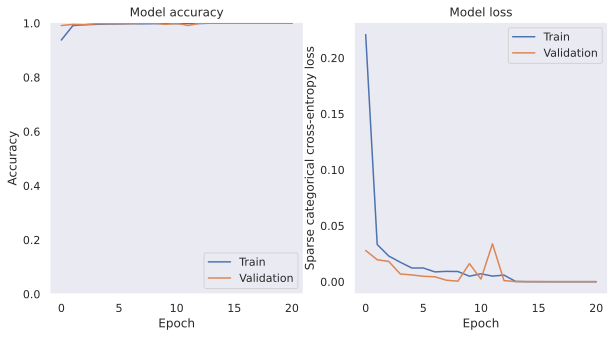

In [ ]:
def plot_learning_curves(training_metrics_csv_path):

  training_metrics = pd.read_csv(training_metrics_csv_path)

  # Se grafican las curvas de aprendizaje para la precisión.
  _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.plot(training_metrics["sparse_categorical_accuracy"])
  ax1.plot(training_metrics["val_sparse_categorical_accuracy"])
  ax1.set(title="Model accuracy", xlabel="Epoch", ylabel="Accuracy")
  ax1.set_ylim(ymin=0)
  ax1.legend(["Train", "Validation"], loc="lower right")

  # Se grafican las curvas de aprendizaje para la pérdida.
  ax2.plot(training_metrics["loss"])
  ax2.plot(training_metrics["val_loss"])
  ax2.set(title="Model loss", xlabel="Epoch", ylabel="Sparse categorical cross-entropy loss")
  ax2.legend(["Train", "Validation"], loc="upper right")


plot_learning_curves(os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"training_metrics_{MODEL_V1_NAME}.csv"))

In [ ]:
# Se carga el modelo almacenado anteriormente.
model_v1 = load_model(os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"best_{MODEL_V1_NAME}.hdf5"))

# Se realiza el proceso de inferencia.
model_v1_test_predictions = model_v1.predict(X_test)

# Se almacenan las predicciones.
pd.DataFrame({"predictions": np.argmax(model_v1_test_predictions, axis=1)}).to_csv(
  os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"{model_v1.name}_test_predictions.csv"),
  index=False
)

Exactitud del modelo: 100.0 %
Precisión del modelo: 100.0 %
Sensibilidad del modelo: 100.0 %
F1 score del modelo: 100.0 %



<Figure size 720x432 with 0 Axes>

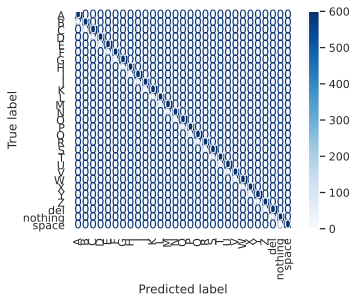

<Figure size 720x432 with 0 Axes>

In [ ]:
def show_model_metrics(test_predictions_csv_path, y_test, labels):

  test_predictions = pd.read_csv(test_predictions_csv_path)["predictions"]

  # Se muestran las métricas del modelo. Se usa "weighted" porque las clases no están
  # perfectamente balanceadas, aunque esto no es muy necesario.
  print(f'Exactitud del modelo: {accuracy_score(y_test, test_predictions) * 100} %')
  print(f'Precisión del modelo: {precision_score(y_test, test_predictions, average="weighted") * 100} %')
  print(f'Sensibilidad del modelo: {recall_score(y_test, test_predictions, average="weighted") * 100} %')
  print(f'F1 score del modelo: {f1_score(y_test, test_predictions, average="weighted") * 100} %\n')

  # Se grafica la matriz de confusión del modelo.
  confusion_matrix_ = confusion_matrix(y_test, test_predictions)
  display_ = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, display_labels=labels)
  display_.plot(cmap="Blues", xticks_rotation='vertical', values_format='d')


unique_labels = sorted(set(Name))

show_model_metrics(
  os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"{MODEL_V1_NAME}_test_predictions.csv"),
  y_test,
  unique_labels
)
plt.figure(figsize=(10,6))

## Imágenes del dataset con su respectiva predicción

In [ ]:
def show_image_with_predictions( dir=data_dir, letra="A", archivo= "A1.jpg"):
  if (dir== data_dir):
    path=os.path.join(dir, letra)
    im_toshow = cv2.imread(os.path.join(path, archivo))
    plt.rcParams["axes.grid"] = False 
    plt.imshow(im_toshow)
  if (dir==  data_dir_test):  
    path=dir
    im_toshow = cv2.imread(os.path.join(dir, archivo))
    plt.rcParams["axes.grid"] = False 
    plt.imshow(im_toshow)  

  image=load_img(os.path.join(path,archivo), grayscale=False, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
  image=img_to_array(image)
  image=image/255.0
  image= np.array(image)  
  d=[]
  d+=[image]
  d= np.array(d)
  a= model_v1.predict(d)
  pred= np.argmax(a, axis=1)
  pred[0]
  prediccion= unique_labels[pred[0]]
  
  
  plt.title ("True label: " + letra)
  plt.xlabel("Predicted label: "+prediccion)

 

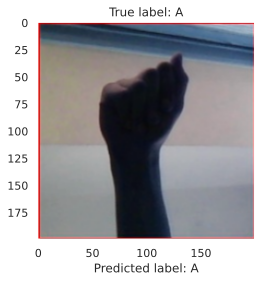

In [ ]:
show_image_with_predictions( dir=data_dir, letra="A", archivo= "A1.jpg")

In [ ]:
test=os.listdir(data_dir_test)
test= sorted(test)
len(test)

28

In [ ]:
iter_test = iter(test)
cont=0

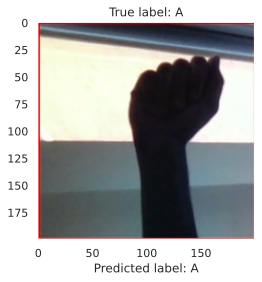

In [ ]:
if (cont< 28) :
  a=next(iter_test)
  txt = a
  x = re.findall("\w*_", txt)
  x = re.sub("_", "", x[0])
  show_image_with_predictions( data_dir_test, x, a  )
  cont += 1
else: 
  iter_test = iter(test)
  cont=0


## Captura de imagenes desde videos

##### Intento 1

In [ ]:
import cv2
cap= cv2.VideoCapture('/content/drive/MyDrive/Tecno-Inclusion/Videos_ASL/MAMA2.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        
        break    
    cv2.imwrite('mama_'+str(i)+'.jpg',cv2.flip(frame, 1))
    
    i+=1
    
print(i)
cap.release()
cv2.destroyAllWindows()

316


In [ ]:
tam= i
i=0
predicciones=[]
dir= '/content/mama_'
for i in range(tam):
  path_image= dir+str(i)+'.jpg'
  image=load_img(path_image, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
  image=img_to_array(image)
  image=image/255.0
  image= np.array(image)  
  d=[]
  d+=[image]
  d= np.array(d)
  a= model_v1.predict(d)
  pred= np.argmax(a, axis=1)
  pred[0]
  prediccion= unique_labels[pred[0]]
  predicciones.append(prediccion)


In [ ]:
predicciones

['B',
 'E',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'E',
 'E',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'E',
 'E',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'E',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E'

##### Intento2 

In [ ]:
import cv2
cap= cv2.VideoCapture('/content/drive/MyDrive/Tecno-Inclusion/Videos_ASL/MAMA.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        
        break    
    cv2.imwrite('mama'+str(i)+'.jpg',cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE))
    
    i+=1
    
print(i)
cap.release()
cv2.destroyAllWindows()

132


In [ ]:
tam= i
i=0
predicciones=[]
dir= '/content/mama'
for i in range(tam):
  path_image= dir+str(i)+'.jpg'
  image=load_img(path_image, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
  image=img_to_array(image)
  image=image/255.0
  image= np.array(image)  
  d=[]
  d+=[image]
  d= np.array(d)
  a= model_v1.predict(d)
  pred= np.argmax(a, axis=1)
  pred[0]
  prediccion= unique_labels[pred[0]]
  predicciones.append(prediccion)


In [ ]:
predicciones

['P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'Z',
 'Z',
 'Z',
 'Q',
 'Z',
 'Z',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'M',
 'Z',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'T',
 'T',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'F',
 'F',
 'P',
 'P',
 'P',
 'P',
 'O',
 'O']

##### Intento 3 

In [ ]:
import cv2
cap= cv2.VideoCapture('/content/drive/MyDrive/Tecno-Inclusion/Videos_ASL/LOCA.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        
        break    
    cv2.imwrite('loca'+str(i)+'.jpg',cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE))
    
    i+=1
    
print(i)
cap.release()
cv2.destroyAllWindows()

149


In [ ]:
tam= i
i=0
predicciones=[]
dir= '/content/loca'
for i in range(tam):
  path_image= dir+str(i)+'.jpg'
  image=load_img(path_image, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
  image=img_to_array(image)
  image=image/255.0
  image= np.array(image)  
  d=[]
  d+=[image]
  d= np.array(d)
  a= model_v1.predict(d)
  pred= np.argmax(a, axis=1)
  pred[0]
  prediccion= unique_labels[pred[0]]
  predicciones.append(prediccion)

In [ ]:
predicciones

['F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'P',
 'P',
 'P',
 'Y',
 'P',
 'P',
 'P',
 'P',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'F',
 'F',
 'F',
 'Y',
 'G',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

##### Intento 4 

In [ ]:
import cv2
cap= cv2.VideoCapture('/content/drive/MyDrive/Tecno-Inclusion/Videos_ASL/LOCA2.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        
        break    
    cv2.imwrite('loca2_'+str(i)+'.jpg',cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE))
    
    i+=1
    
print(i)
cap.release()
cv2.destroyAllWindows()

161


In [ ]:
tam= i
i=0
predicciones=[]
dir= '/content/loca2_'
for i in range(tam):
  path_image= dir+str(i)+'.jpg'
  image=load_img(path_image, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
  image=img_to_array(image)
  image=image/255.0
  image= np.array(image)  
  d=[]
  d+=[image]
  d= np.array(d)
  a= model_v1.predict(d)
  pred= np.argmax(a, axis=1)
  pred[0]
  prediccion= unique_labels[pred[0]]
  predicciones.append(prediccion)

In [ ]:
predicciones

['D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'R',
 'R',
 'R',
 'B',
 'B',
 'B',
 'space',
 'space',
 'space',
 'space',
 'O',
 'space',
 'O',
 'O',
 'O',
 'del',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'F',
 'O',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'space',
 'B',
 'M',
 'M',
 'del',
 'B',
 'O',
 'E',
 'E',
 'E',
 'E',
 'E'

##### Intento 5

In [ ]:
import cv2
cap= cv2.VideoCapture('/content/drive/MyDrive/Tecno-Inclusion/Videos_ASL/HOLA.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        
        break    
    cv2.imwrite('hola'+str(i)+'.jpg',frame)
    
    i+=1
    
print(i)
cap.release()
cv2.destroyAllWindows()

215


In [ ]:
tam= i
i=0
predicciones=[]
dir= '/content/hola'
for i in range(tam):
  path_image= dir+str(i)+'.jpg'
  image=load_img(path_image, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
  image=img_to_array(image)
  image=image/255.0
  image= np.array(image)  
  d=[]
  d+=[image]
  d= np.array(d)
  a= model_v1.predict(d)
  pred= np.argmax(a, axis=1)
  pred[0]
  prediccion= unique_labels[pred[0]]
  predicciones.append(prediccion)

In [ ]:
predicciones

['P',
 'P',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'G',
 'R',
 'R',
 'G',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'P',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'R',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'J',
 'P',
 'P',
 'P',
 'J',
 'J',
 'J',
 'J',
 'J',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'J',
 'P',
 'P',
 'P'

##### Intento 6 

In [ ]:
import cv2
cap= cv2.VideoCapture('/content/drive/MyDrive/Tecno-Inclusion/Videos_ASL/MAMA3.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        
        break    
    cv2.imwrite('mama3_'+str(i)+'.jpg',cv2.flip(frame, 1))
    
    i+=1
    
print(i)
cap.release()
cv2.destroyAllWindows()

206


In [ ]:
tam= i
i=0
predicciones=[]
dir= '/content/mama3_'
for i in range(tam):
  path_image= dir+str(i)+'.jpg'
  image=load_img(path_image, color_mode='rgb', target_size=RESNET50_INPUT_SHAPE[:2])
  image=img_to_array(image)
  image=image/255.0
  image= np.array(image)  
  d=[]
  d+=[image]
  d= np.array(d)
  a= model_v1.predict(d)
  pred= np.argmax(a, axis=1)
  pred[0]
  prediccion= unique_labels[pred[0]]
  predicciones.append(prediccion)

In [ ]:
predicciones

['M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'O',
 'E',
 'O',
 'O',
 'E',
 'E',
 'O',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'O',
 'O',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'A',
 'A',
 'A',
 'A',
 'M',
 'O',
 'O',
 'O',
 'M',
 'M',
 'E',
 'E',
 'E',
 'E',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'M',
 'M',
 'M',
 'O',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'E',
 'O',
 'O',
 'O',
 'E',
 'O',
 'O',
 'O',
 'O',
 'O',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E'